In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import mlflow
from mlflow.tracking import MlflowClient

In [2]:
plt.style.use("~/nice.mplstyle")

In [9]:
def get_stitched_metrics(tracking_uri, experiment_id, metric_name):
    print(f"Connecting to: {tracking_uri}")
    client = MlflowClient(tracking_uri=tracking_uri)

    # 1. Search for all runs in the experiment, sorted by start time
    #    This ensures we process the 'first' run first, then the restart, etc.
    runs = client.search_runs(
        experiment_ids=[experiment_id],
        order_by=["attribute.start_time ASC"]
    )

    if not runs:
        print(f"No runs found in experiment {experiment_id}")
        return None

    print(f"Found {len(runs)} runs. Stitching metrics...")

    stitched_data = []
    cumulative_step_offset = 0
    last_max_step = 0
    
    for i, run in enumerate(runs):
        run_id = run.info.run_id
        
        try:
            # Pull the entire history of the metric for this run
            history = client.get_metric_history(run_id, key=metric_name)
            
            if not history:
                print(f"  [Run {i+1}/{len(runs)}] {run_id}: No data for '{metric_name}'")
                continue

            # Check if this run's steps start near 0 (indicating a counter reset)
            # If so, we add the max step from the previous run to these steps
            current_run_min_step = min(m.step for m in history)
            
            # If the new run starts at a step significantly lower than where the last one ended,
            # we assume the counter reset and apply the offset.
            if i > 0 and current_run_min_step < last_max_step:
                cumulative_step_offset = last_max_step

            print(f"  [Run {i+1}/{len(runs)}] {run_id}: Found {len(history)} points. Applying offset: {cumulative_step_offset}")

            current_run_max = 0
            for m in history:
                real_step = m.step + cumulative_step_offset
                stitched_data.append({
                    "run_id": run_id,
                    "original_step": m.step,
                    "global_step": real_step, # The continuous step for plotting
                    metric_name: m.value,
                    "timestamp": m.timestamp
                })
                current_run_max = max(current_run_max, real_step)
            
            # Update the tracker for the next iteration
            last_max_step = current_run_max

        except Exception as e:
            print(f"  Error processing run {run_id}: {e}")

    result = pd.DataFrame(stitched_data)
    result = result.sort_values("global_step")
    return result

In [16]:
local_mlflow_dir = "/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/training-steps/steps060k/logs/mlflow"
tracking_uri = f"file://{local_mlflow_dir}"

experiment_id = "163128462297733984"
metric_name = "train_multi_dataset_loss_step"

tsdf = get_stitched_metrics(tracking_uri, experiment_id, "train_multi_dataset_loss_step")
tedf = get_stitched_metrics(tracking_uri, experiment_id, "train_multi_dataset_loss_epoch")
vsdf = get_stitched_metrics(tracking_uri, experiment_id, "val_multi_dataset_loss_step")
vedf = get_stitched_metrics(tracking_uri, experiment_id, "val_multi_dataset_loss_epoch")

Connecting to: file:///pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/training-steps/steps060k/logs/mlflow
Found 3 runs. Stitching metrics...
  [Run 1/3] 58e25e814b2d4e55b1577547f18d0c27: Found 219 points. Applying offset: 0
  [Run 2/3] 148c68c072bb4c6c823dbbfffc19465d: Found 116 points. Applying offset: 21899
  [Run 3/3] 214f0cdbb89344d5a89b6245de56640a: Found 222 points. Applying offset: 53798
Connecting to: file:///pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/training-steps/steps060k/logs/mlflow
Found 3 runs. Stitching metrics...
  [Run 1/3] 58e25e814b2d4e55b1577547f18d0c27: Found 7 points. Applying offset: 0
  [Run 2/3] 148c68c072bb4c6c823dbbfffc19465d: Found 3 points. Applying offset: 0
  [Run 3/3] 214f0cdbb89344d5a89b6245de56640a: Found 7 points. Applying offset: 0
Connecting to: file:///pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/training-steps/steps060k/logs/mlflow
Found 3 runs. Stitching metrics...
  [Run 1

In [33]:
local_mlflow_dir = "/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/base/mlpnoise32/logs/mlflow"
tracking_uri = f"file://{local_mlflow_dir}"

experiment_id = "185369188354684115"
reftsdf = get_stitched_metrics(tracking_uri, experiment_id, "train_multi_dataset_loss_step")
reftedf = get_stitched_metrics(tracking_uri, experiment_id, "train_multi_dataset_loss_epoch")
refvsdf = get_stitched_metrics(tracking_uri, experiment_id, "val_multi_dataset_loss_step")
refvedf = get_stitched_metrics(tracking_uri, experiment_id, "val_multi_dataset_loss_epoch")

Connecting to: file:///pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/base/mlpnoise32/logs/mlflow
Found 1 runs. Stitching metrics...
  [Run 1/1] 7f97a1fdd4a94afc8f47f70272288d26: Found 300 points. Applying offset: 0
Connecting to: file:///pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/base/mlpnoise32/logs/mlflow
Found 1 runs. Stitching metrics...
  [Run 1/1] 7f97a1fdd4a94afc8f47f70272288d26: Found 42 points. Applying offset: 0
Connecting to: file:///pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/base/mlpnoise32/logs/mlflow
Found 1 runs. Stitching metrics...
  [Run 1/1] 7f97a1fdd4a94afc8f47f70272288d26: Found 3731 points. Applying offset: 0
Connecting to: file:///pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/base/mlpnoise32/logs/mlflow
Found 1 runs. Stitching metrics...
  [Run 1/1] 7f97a1fdd4a94afc8f47f70272288d26: Found 41 points. Applying offset: 0


In [68]:
local_mlflow_dir = "/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/base/sharednoise32/logs/mlflow"
tracking_uri = f"file://{local_mlflow_dir}"

experiment_id = "838324996070840683"
r2tsdf = get_stitched_metrics(tracking_uri, experiment_id, "train_multi_dataset_loss_step")
r2tedf = get_stitched_metrics(tracking_uri, experiment_id, "train_multi_dataset_loss_epoch")
r2vsdf = get_stitched_metrics(tracking_uri, experiment_id, "val_multi_dataset_loss_step")
r2vedf = get_stitched_metrics(tracking_uri, experiment_id, "val_multi_dataset_loss_epoch")

Connecting to: file:///pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/base/sharednoise32/logs/mlflow
Found 2 runs. Stitching metrics...
  [Run 1/2] ffeef7be6ab24b21810ceccfd10731d0: Found 296 points. Applying offset: 0
  [Run 2/2] bb336c2e69dd49b1b9b53b8fcbfd44bc: Found 10 points. Applying offset: 29599
Connecting to: file:///pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/base/sharednoise32/logs/mlflow
Found 2 runs. Stitching metrics...
  [Run 1/2] ffeef7be6ab24b21810ceccfd10731d0: Found 40 points. Applying offset: 0
  [Run 2/2] bb336c2e69dd49b1b9b53b8fcbfd44bc: Found 2 points. Applying offset: 0
Connecting to: file:///pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/crps06h/experiments/base/sharednoise32/logs/mlflow
Found 2 runs. Stitching metrics...
  [Run 1/2] ffeef7be6ab24b21810ceccfd10731d0: Found 3640 points. Applying offset: 0
  [Run 2/2] bb336c2e69dd49b1b9b53b8fcbfd44bc: Found 91 points. Applying offset: 3639
Connecting to: file:///ps

<Axes: >

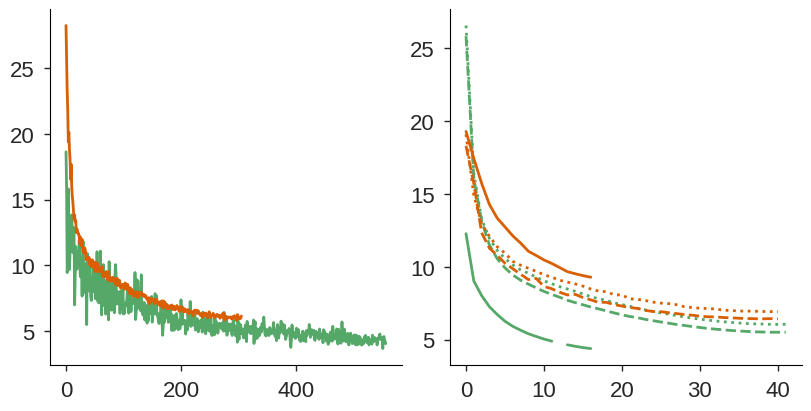

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)

#for df, key in zip([tsdf, vsdf], ["train_multi_dataset_loss_step", "val_multi_dataset_loss_step"]):
#    axs[0].plot(
#        df["global_step"].values,
#        df[key].values,
#        marker="o",
#        linestyle="",
#    )
#    
#for df, key in zip([tedf, vedf], ["train_multi_dataset_loss_epoch", "val_multi_dataset_loss_epoch"]):
#    axs[1].plot(
#        df["global_step"].values,
#        df[key].values,
#        marker="o",
#        linestyle="",
#    )
#for df, key in zip([reftedf, refvedf], ["train_multi_dataset_loss_epoch", "val_multi_dataset_loss_epoch"]):
#    axs[1].plot(
#        df["global_step"].values,
#        df[key].values,
#        marker="o",
#        linestyle="",
#    )
(.5*tsdf["train_multi_dataset_loss_step"]).plot(ax=axs[0], x="global_step")
r2tsdf["train_multi_dataset_loss_step"].plot(ax=axs[0], x="global_step")
#vsdf["val_multi_dataset_loss_step"].plot(ax=axs[0], x="global_step")
(.5*tedf["train_multi_dataset_loss_epoch"]).plot(ax=axs[1])
r2tedf["train_multi_dataset_loss_epoch"].plot(ax=axs[1], color="C0", linestyle=":")
reftedf["train_multi_dataset_loss_epoch"].plot(ax=axs[1], color="C0", linestyle="--")

vedf["val_multi_dataset_loss_epoch"].plot(ax=axs[1])
refvedf["val_multi_dataset_loss_epoch"].plot(ax=axs[1], color="C1", linestyle="--")
r2vedf["val_multi_dataset_loss_epoch"].plot(ax=axs[1], color="C1", linestyle=":")

## is the loss difference due to the higher weight decay value?

In [53]:
local_mlflow_dir = "/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/regularization/wp10/logs/mlflow"
tracking_uri = f"file://{local_mlflow_dir}"

experiment_id = "907202663336847516"
wp10tsdf = get_stitched_metrics(tracking_uri, experiment_id, "train_mse_loss_step")
wp10tedf = get_stitched_metrics(tracking_uri, experiment_id, "train_mse_loss_epoch")
wp10vsdf = get_stitched_metrics(tracking_uri, experiment_id, "val_mse_loss_step")
wp10vedf = get_stitched_metrics(tracking_uri, experiment_id, "val_mse_loss_epoch")

Connecting to: file:///pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/regularization/wp10/logs/mlflow
Found 1 runs. Stitching metrics...
  [Run 1/1] 2bba6f10319540078d1efbcc1e9577ad: Found 300 points. Applying offset: 0
Connecting to: file:///pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/regularization/wp10/logs/mlflow
Found 1 runs. Stitching metrics...
  [Run 1/1] 2bba6f10319540078d1efbcc1e9577ad: Found 42 points. Applying offset: 0
Connecting to: file:///pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/regularization/wp10/logs/mlflow
Found 1 runs. Stitching metrics...
  [Run 1/1] 2bba6f10319540078d1efbcc1e9577ad: Found 3608 points. Applying offset: 0
Connecting to: file:///pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/regularization/wp10/logs/mlflow
Found 1 runs. Stitching metrics...
  [Run 1/1] 2bba6f10319540078d1efbcc1e9577ad: Found 41 points. Applying offset: 0


In [64]:
local_mlflow_dir = "/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/regularization/wp01/logs/mlflow"
tracking_uri = f"file://{local_mlflow_dir}"

experiment_id = "409584416965544161"
wp01tsdf = get_stitched_metrics(tracking_uri, experiment_id, "train_mse_loss_step")
wp01tedf = get_stitched_metrics(tracking_uri, experiment_id, "train_mse_loss_epoch")
wp01vsdf = get_stitched_metrics(tracking_uri, experiment_id, "val_mse_loss_step")
wp01vedf = get_stitched_metrics(tracking_uri, experiment_id, "val_mse_loss_epoch")

Connecting to: file:///pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/regularization/wp01/logs/mlflow
Found 1 runs. Stitching metrics...
  [Run 1/1] ba209201e3aa49fea8d89a16dd5f30bc: Found 300 points. Applying offset: 0
Connecting to: file:///pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/regularization/wp01/logs/mlflow
Found 1 runs. Stitching metrics...
  [Run 1/1] ba209201e3aa49fea8d89a16dd5f30bc: Found 42 points. Applying offset: 0
Connecting to: file:///pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/regularization/wp01/logs/mlflow
Found 1 runs. Stitching metrics...
  [Run 1/1] ba209201e3aa49fea8d89a16dd5f30bc: Found 3608 points. Applying offset: 0
Connecting to: file:///pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/regularization/wp01/logs/mlflow
Found 1 runs. Stitching metrics...
  [Run 1/1] ba209201e3aa49fea8d89a16dd5f30bc: Found 41 points. Applying offset: 0


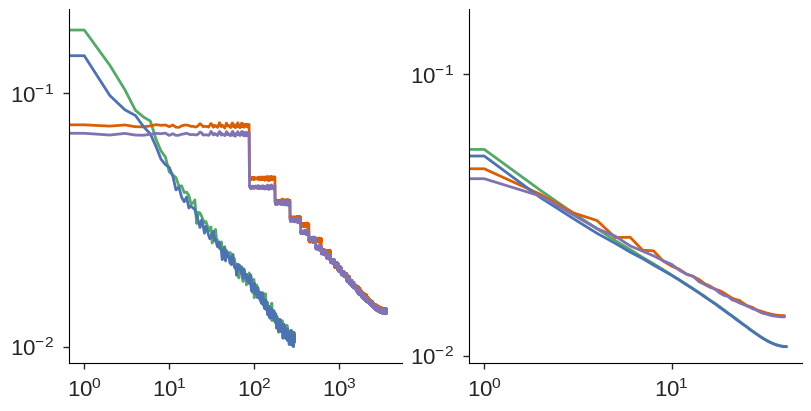

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)

wp10tsdf["train_mse_loss_step"].plot(ax=axs[0], x="global_step")
wp10vsdf["val_mse_loss_step"].plot(ax=axs[0], x="global_step")
wp10tedf["train_mse_loss_epoch"].plot(ax=axs[1])
wp10vedf["val_mse_loss_epoch"].plot(ax=axs[1])

wp01tsdf["train_mse_loss_step"].plot(ax=axs[0], x="global_step")
wp01vsdf["val_mse_loss_step"].plot(ax=axs[0], x="global_step")
wp01tedf["train_mse_loss_epoch"].plot(ax=axs[1])
wp01vedf["val_mse_loss_epoch"].plot(ax=axs[1])
[ax.set(xscale="log", yscale="log") for ax in axs];